# Computing initial and terminal states

In this tutorial, you will learn how to use the [GPCCAEstimator](https://cellrank.readthedocs.io/en/stable/api/cellrank.estimators.GPCCA.html) to...

- compute macrostates of cell state changes.
- visualize a coarse-grained transition matrix among these macrostates.
- automatically and manually classify macrostates as initial, terminal or intermediate.

<div class="alert alert-info">
Important

If you use the `GPCCAEstimator` in your research, plese do not forget to cite both CellRank as well as the original GPCCA papers: <cite cite-date="reuter:18,reuter:19"></cite>. See ["how to cite us"](https://cellrank.readthedocs.io/en/stable/citing.html) for more info. 

</div>

This tutorial does not depend on the kernel you used to compute a cell-cell transiton matrix. No matter whether you used the [VelocityKernel](https://cellrank.readthedocs.io/en/stable/api/cellrank.kernels.VelocityKernel.html), the [PseudotimeKernel](https://cellrank.readthedocs.io/en/stable/api/cellrank.kernels.PseudotimeKernel.html), the [CytoTRACEKernel](https://cellrank.readthedocs.io/en/stable/api/cellrank.kernels.CytoTRACEKernel.html), or any other cellrank kernel to compute transition probabilities, you may always follow the steps outlined in this tutorial to compute initial and terminal states. This is explained in more detail in our [getting started](https://cellrank.readthedocs.io/en/stable/getting_started.html) tutorial and summarized in the figure below: 

<img src="_static/img/cellrank_structure.jpg" width="800" alt="The GPCCA estimator is independent of the kernel you used to compute a cell-cell transition matrix. ">

**Fig** | CellRank is a modular framework where every kernel may be used to compute initial and terminal states.

To demonstrate the appproach in this tutorial, we will use a scRNA-seq dataset of pancreas development at embyonic day E15.5 <cite data-cite="bastidas-ponce:19"></cite>. We used this dataset in our [cellrank meets rna velocity tutorial](https://cellrank.readthedocs.io/en/stable/cellrank_meets_rna_velocity.html) to compute a cell-cell transition matrix using the `VelocityKernel`; this tutorial builds on the transition matrix computed there. 

<div class="alert alert-info">
Important

If you want to run this on your own data, you will need...

- a scRNA-seq dataset for which you computed a cell-cell transition matrix using any CellRank kernel. For each kernel, there exist individual tutorials that teach you how to use them. 

</div>

This tutorial notebook can be downloaded using the following [link](https://github.com/theislab/cellrank_notebooks/raw/master/tutorials/initial_terminal_states.ipynb).

## Import packages & data

In [1]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/theislab/cellrank@dev

In [2]:
import scvelo as scv
import scanpy as sc
import cellrank as cr

scv.settings.verbosity = 3
scv.settings.set_figure_params("scvelo")
cr.settings.verbosity = 2

In [3]:
import warnings

warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

Read AnnData object from disk (or download) and reconstruct a [Precomputed Kernel](https://cellrank.readthedocs.io/en/stable/api/cellrank.kernels.PrecomputedKernel.html) from it. 

In [4]:
adata = sc.read('datasets/ML_2022-06-23_pancreas_with_transition_matrix.h5ad')

In [5]:
pk = cr.kernels.PrecomputedKernel(adata, backward=False)
print(pk)

Using transition matrix from `adata.obsp['T_fwd']`
PrecomputedKernel[origin="adata.obsp['T_fwd']"]


<div class="alert alert-info">
Important

The `PrecomputedKernel` allows you to input any transition matrix to a CellRank `kernel` object; it is essentially an iterface between CellRank's estimators and external methods which give you transition matrices. We use it here because we have precomputed the transition matrix in another tutorial and want to use it here for further analysis. Using a `PrecomputeKernel` allows you to make use of CellRank's estimator functionalities, no matter how your transition matrix has been computed!

**In general**, don't worry about the `PrecomputedKernel` and just continue to use your original kernel to initialize an estimator. 

</div>

As a reminder, below is a UMAP <cite data-cite="mcinnes:18,becht:19"></cite> with cluster labels of this dataset <cite data-cite="bastidas-ponce:19"></cite>. In this tutorial, we will automatically identify the initial and terminal states. 

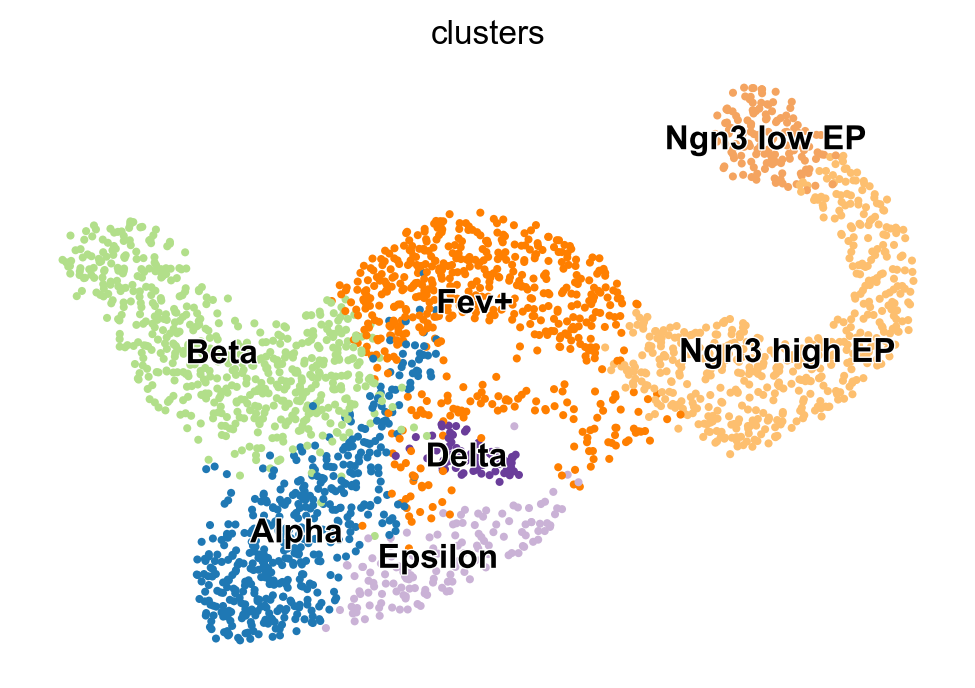

In [6]:
scv.pl.scatter(adata)

## Initialize an estimator 

Estimators allow you to analyze cell-state dynamics in CellRank. We initialize a `GPCCAEstimator` here by passing the kernel object. This works for *every* kernel. 

In [7]:
g = cr.estimators.GPCCA(pk)
print(g)

GPCCA[n=2531, kernel=PrecomputedKernel[origin="adata.obsp['T_fwd']"]]


We use the `GPCCAEstimator` below to compute initial & terminal states; it may further be used to compute fate probabilities as we explain in the [fate probabilities & driver genes tutorial](https://cellrank.readthedocs.io/en/stable/notebooks/tutorials/fate_probabilities.html). 

<div class="alert alert-info">
Important

You can interact with the `GPCCAEstimator` in two ways:
- via the `fit()` and `predict()` methods; this is very convenient but offers less control. 
- low-level, by computing the schur decomposition, the macrostates, etc. While there are a few more method cells involved here, it offers you more control. 
    
We'll demonstrate both modes in this tutorial. 

</div>

## Basic usage: `fit()` and `predict()`

We fit the estimator, this computes a [Schur decompsition](https://en.wikipedia.org/wiki/Schur_decomposition) and uses the GPCCA algorithm <cite data-cite="reuter:18,reuter:19"></cite> as implemented in [pyGPCCA](https://pygpcca.readthedocs.io/en/latest/) to compute macrostates by maximizing for metastability.  

Computing Schur decomposition
Mat Object: 1 MPI processes
  type: seqdense
9.9999999999999978e-01 -1.6027616115423804e-02 -6.9999122819399214e-05 -3.0170264112083060e-02 7.9114474346406118e-04 -2.3379307555267200e-03 3.1099392748332021e-02 -1.2028052641645045e-02 4.5402303093021922e-02 -3.9545106553962851e-02 -1.0459780698478143e-02 -1.0117351207690200e-02 
0.0000000000000000e+00 9.8689949635914975e-01 -1.5019260264085295e-02 -9.6502345112150275e-03 -8.2436478078494781e-03 4.8117357524504597e-03 -2.7577126488919036e-03 -5.9013767212245738e-03 -3.2081374085749730e-02 1.5507024222048180e-02 -8.8740262830442930e-03 -6.2602296077992085e-03 
0.0000000000000000e+00 0.0000000000000000e+00 9.5955555167360695e-01 -4.7106747151722935e-03 -5.4015589471963690e-03 1.0880863078896181e-03 1.3937597585321894e-03 1.8372105147623009e-03 6.3024769849277327e-03 -1.1483429360858510e-02 9.0685877814312213e-03 2.1204960649007783e-02 
0.0000000000000000e+00 0.0000000000000000e+00 0.0000000000000000e+00 8.5826

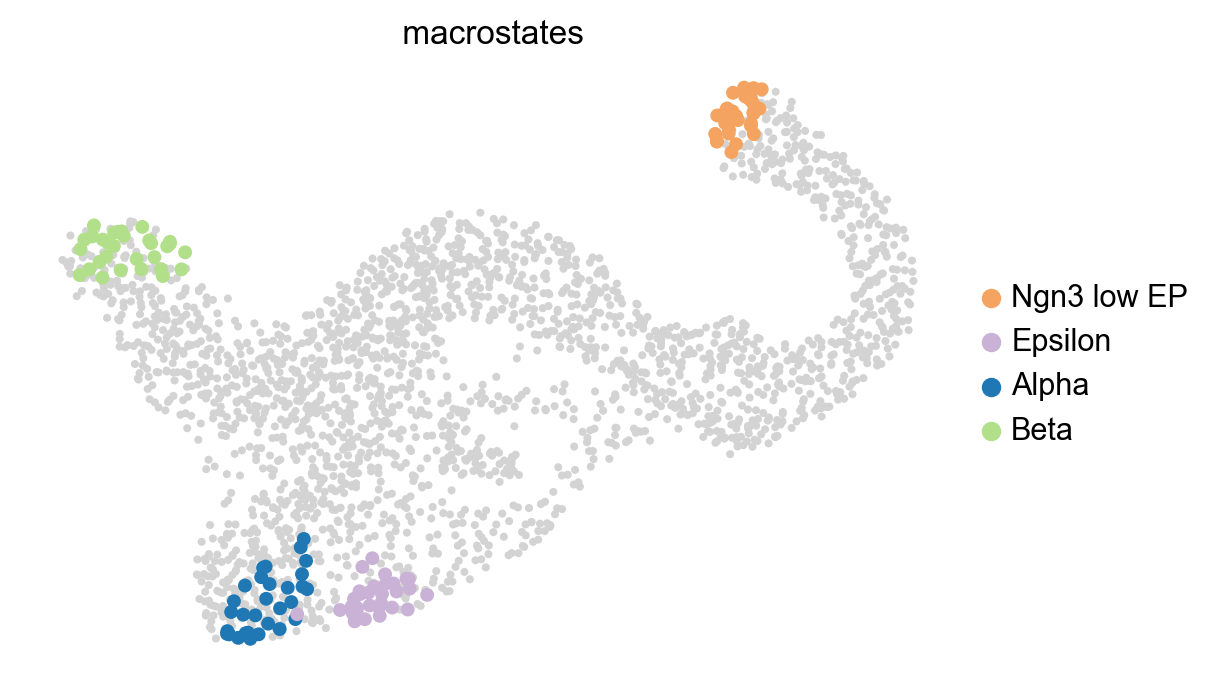

In [8]:
# g.compute_schur()
g.fit(cluster_key='clusters', n_states=[4, 12])
g.plot_macrostates(discrete=True, legend_loc='right', s=100)

Using `n_states=[a, b]`, we told the algorithm to scan this interval for the optimal number of macrostates. It identified 4 macrostates which we show above in the UMAP. For each macrostate, we display the `n_cells` cells most strongly associated with it. Each macrostate was automatically assigned a label by associating it with the cluster labels stored in `adata.obs['clusters']`; this is controled using `cluster_key`. 

<div class="alert alert-warning">
Warning

Make sure to have the scientific computing libraries [PETSc](https://petsc.org/release/) and [SLEPc](https://slepc.upv.es/) installed for maximum performance. On most machines, this is strongly recommended if your datasets consists of over **10k cells**. See our [installation instructions](https://cellrank.readthedocs.io/en/stable/installation.html). 

</div>

In the next step, we use the `predict()` method to classify our macrostates as either initial, intermediate or terminal. 

In [10]:
g.macrostates

index
AAACCTGAGAGGGATA-1-3    NaN
AAACCTGAGGCAATTA-1-3    NaN
AAACCTGGTAAGTGGC-1-3    NaN
AAACCTGTCCCTCTTT-1-3    NaN
AAACGGGAGTAGCGGT-1-3    NaN
                       ... 
TTTGGTTTCCTTTCGG-1-3    NaN
TTTGTCAAGAATGTGT-1-3    NaN
TTTGTCAAGTGACATA-1-3    NaN
TTTGTCATCGAATGCT-1-3    NaN
TTTGTCATCTGTTTGT-1-3    NaN
Length: 2531, dtype: category
Categories (4, object): ['Ngn3 low EP', 'Epsilon', 'Alpha', 'Beta']

In [11]:
g.compute_states()

AttributeError: 'StatesHolder' object has no attribute 'cat'

In [9]:
g.predict()
g.plot_terminal_states(discrete=True, legend_loc='right', s=100)

AttributeError: 'StatesHolder' object has no attribute 'cat'

In [14]:
g._compute_initial_states()

Adding `adata.obs['initial_states']`
       `adata.obs['initial_states_colors']`



In [15]:
adata.obs['initial_states']

index
AAACCTGAGAGGGATA-1-3    NaN
AAACCTGAGGCAATTA-1-3    NaN
AAACCTGGTAAGTGGC-1-3    NaN
AAACCTGTCCCTCTTT-1-3    NaN
AAACGGGAGTAGCGGT-1-3    NaN
                       ... 
TTTGGTTTCCTTTCGG-1-3    NaN
TTTGTCAAGAATGTGT-1-3    NaN
TTTGTCAAGTGACATA-1-3    NaN
TTTGTCATCGAATGCT-1-3    NaN
TTTGTCATCTGTTTGT-1-3    NaN
Name: initial_states, Length: 2531, dtype: category
Categories (1, object): ['Ngn3 low EP']

## What's next? 

In this tutorial, you learned how to use CellRank to compute a transition matrix based on the CytoTRACE pseudotime and how it can be visualized in low dimensions. The real power of CellRank comes in when you use estimators to analyze the transition matrix directly, rather than projecting it. For the next steps, we recommend...

- going through the [initial & terminal states tutorial](https://cellrank.readthedocs.io/en/stable/initial_terminal.html) to learn how to use the transition matrix to automatically identify initial and terminal states. 
- taking a look at the [full API](https://cellrank.readthedocs.io/en/stable/api.html) to learn about parameter values you can use to adapt these computations to your data. 
- reading the original CytoTRACE publication and considering limitations of this appraoch <cite data-cite="gulati:20"></cite>. 

If you encounter any bugs in the code, our if you have suggestions for new features, please open an [issue](https://github.com/theislab/cellrank/issues/new/choose). If you have a general question or something you would like to discuss with us, please post on the [scverse discourse](https://discourse.scverse.org/c/ecosytem/cellrank/40). 

## Package versions

In [14]:
cr.logging.print_versions()

cellrank==1.5.1+gc04c690e.d20220610 scanpy==1.7.2 anndata==0.8.0 numpy==1.21.4 numba==0.51.2 scipy==1.5.3 pandas==1.3.3 pygpcca==1.0.2 scikit-learn==0.24.0 statsmodels==0.12.1 python-igraph==0.8.3 scvelo==0.2.4 pygam==0.8.0 matplotlib==3.3.3 seaborn==0.11.0
